In [3]:
import datetime
import pickle
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
from datetime import datetime as dt
from io import BytesIO
import boto3
import multiprocessing as mp
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

%run src/columns.py
%run src/data-cleaning.py
%run src/feature-engineering.py
%run src/modeling.py
%run src/payments.py

# Load Data

In [2]:
csv_file_names = ('LoanStats3a_securev1.csv', 'LoanStats3b_securev1.csv', 'LoanStats3c_securev1.csv', 'LoanStats3d_securev1.csv',
                  'LoanStats_securev1_2016Q1.csv', 'LoanStats_securev1_2016Q2.csv', 'LoanStats_securev1_2016Q3.csv',
                  'LoanStats_securev1_2016Q4.csv', 'LoanStats_securev1_2017Q1.csv', 'LoanStats_securev1_2017Q2.csv', 
                  'LoanStats_securev1_2017Q3.csv', 'LoanStats_securev1_2017Q4.csv', 'LoanStats_securev1_2018Q1.csv',
                  'LoanStats_securev1_2018Q2.csv', 'LoanStats_securev1_2018Q3.csv', 'LoanStats_securev1_2018Q4.csv')

In [3]:
raw_loans = load_loan_data_from_s3(csv_file_names, columns_to_use, number_of_rows=None)

In [4]:
raw_loans.dropna(subset=['loan_amnt'], inplace=True)

In [5]:
raw_loans.head()

,id,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,5000.0,36 months,10.65%,162.87,B,10+ years,RENT,24000.0,Verified,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,2500.0,60 months,15.27%,59.83,C,< 1 year,RENT,30000.0,Source Verified,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,2400.0,36 months,15.96%,84.33,C,10+ years,RENT,12252.0,Not Verified,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,10000.0,36 months,13.49%,339.31,C,10+ years,RENT,49200.0,Source Verified,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,3000.0,60 months,12.69%,67.79,B,1 year,RENT,80000.0,Source Verified,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [6]:
raw_loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2257919 entries, 0 to 128411
Data columns (total 89 columns):
id                                object
loan_amnt                         float64
term                              object
int_rate                          object
installment                       float64
grade                             object
emp_length                        object
home_ownership                    object
annual_inc                        float64
verification_status               object
issue_d                           object
loan_status                       object
purpose                           object
zip_code                          object
addr_state                        object
dti                               float64
delinq_2yrs                       float64
earliest_cr_line                  object
fico_range_low                    float64
fico_range_high                   float64
inq_last_6mths                    float64
mths_since_last_del

In [9]:
raw_loans.to_pickle('data/df_all_loans_raw.pkl.bz2', compression='bz2')

# Clean Data

In [10]:
def clean_and_prepare_raw_data_for_model(df):
    df = drop_loan_status(df)
    df = drop_joint_applicant_loans(df)
    df = fix_rate_cols(df)
    df.dropna(subset=['issue_d'], inplace=True)
    df = fix_date_cols(df)
    df.sort_values(by='issue_d', inplace=True)
    df = exclude_loans_before_2010(df)
    df = clean_loan_term_col(df)
    df = only_include_36_month_loans(df)
    df = clean_employment_length(df)
    # I doubt we need missing data boolean columns for tree models.
    df = create_missing_data_boolean_columns(df)
    df = fill_nas(df, value=-99)
    #df = add_issue_date_and_month(df) # Ditch this?
    df = add_supplemental_rate_data(df)
    df = create_rate_difference_cols(df)
    df = create_months_since_earliest_cl_col(df)
    #df = create_loan_life_months_col(df)
    df = change_data_types(df)
    df = create_dummy_cols(df)
    df = drop_unnecessary_cols(df)
    df['id'] = df['id'].astype(int)
    df.set_index('id', inplace=True)
    # Need to drop
    
    return df

In [11]:
cleaned_loans = clean_and_prepare_raw_data_for_model(raw_loans)
cleaned_loans.head()

,loan_amnt,int_rate,installment,emp_length,annual_inc,issue_d,dti,delinq_2yrs,fico_range_low,fico_range_high,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
id,,,,,,,,,,,,,,,,,,,,,
478462,10000.0,11.83,331.339996,2.0,40000.0,2010-01-01,0.540000,0,730.0,734.0,...,0,0,0,0,0,0,0,0,0,0
477567,10000.0,14.61,344.760010,5.0,62400.0,2010-01-01,8.460000,0,710.0,714.0,...,0,0,0,0,0,0,0,0,0,0
477585,15000.0,16.00,527.359985,7.0,96000.0,2010-01-01,11.130000,2,660.0,664.0,...,0,0,0,0,0,0,0,0,0,0
474990,20000.0,11.83,662.679993,5.0,105000.0,2010-01-01,13.870000,0,755.0,759.0,...,0,0,0,0,0,0,0,0,0,0
477531,15000.0,15.31,522.229980,10.0,90000.0,2010-01-01,16.790001,0,680.0,684.0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
cleaned_loans.to_pickle('data/df_all_loans_cleaned.pkl.bz2', compression='bz2')

# Split Training/Testing

Now that the data has been cleaned I need to split it up into training and testing data then figure out how to use my old ROI calculation functions.

In [13]:
df_train, df_test = split_training_and_testing_data(cleaned_loans, split_date='2016-04-01')

In [14]:
df_train.head()

,loan_amnt,int_rate,installment,emp_length,annual_inc,issue_d,dti,delinq_2yrs,fico_range_low,fico_range_high,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
id,,,,,,,,,,,,,,,,,,,,,
478462,10000.0,11.83,331.339996,2.0,40000.0,2010-01-01,0.540000,0,730.0,734.0,...,0,0,0,0,0,0,0,0,0,0
477567,10000.0,14.61,344.760010,5.0,62400.0,2010-01-01,8.460000,0,710.0,714.0,...,0,0,0,0,0,0,0,0,0,0
477585,15000.0,16.00,527.359985,7.0,96000.0,2010-01-01,11.130000,2,660.0,664.0,...,0,0,0,0,0,0,0,0,0,0
474990,20000.0,11.83,662.679993,5.0,105000.0,2010-01-01,13.870000,0,755.0,759.0,...,0,0,0,0,0,0,0,0,0,0
477531,15000.0,15.31,522.229980,10.0,90000.0,2010-01-01,16.790001,0,680.0,684.0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
df_train = pd.read_pickle('data/df_training_loans_cleaned.pkl.bz2', compression='bz2')
#df_train.to_pickle('data/df_training_loans_cleaned.pkl.bz2', compression='bz2')

In [11]:
training_loan_amounts = dict(df_train.loc[:, 'loan_amnt'])

In [12]:
training_loan_ids = tuple(df_train.index)

# Payments Data

Now we need to read in the payments data to start calculating ROI.

In [4]:
df_payments_raw = load_raw_payments_data_from_s3('PMTHIST_INVESTOR_201904.csv')

In [5]:
df_payments_raw.head()

,LOAN_ID,RECEIVED_D,RECEIVED_AMT_INVESTORS,PBAL_END_PERIOD_INVESTORS,IssuedDate
0,54734,SEP2009,632.771017,18636.409300,AUG2009
1,54734,OCT2009,632.771017,18188.363925,AUG2009
2,54734,NOV2009,632.771017,17735.877487,AUG2009
3,54734,DEC2009,632.771017,17278.905966,AUG2009
4,54734,JAN2010,632.771017,16817.404904,AUG2009


In [6]:
len(df_payments_raw)

45188621

In [5]:
df_payments_raw['LOAN_ID'].nunique()

2260435

In [20]:
#df_payments.to_pickle('data/raw_payments_data.pkl.bz2', compression='bz2')

In [7]:
df_payments_clean = get_cleaned_payment_history_data(df_payments_raw)
df_payments_clean.head()

/home/ubuntu/consumer-loan-survival-analysis/src/payments.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['mths_since_issue'] = df['mths_since_issue'].astype('uint8')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/ubuntu/consumer-loan-survival-analysis/src/payments.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-doc

,LOAN_ID,RECEIVED_D,RECEIVED_AMT_INVESTORS,PBAL_END_PERIOD_INVESTORS,mths_since_issue
0,54734,2009-09-01,632.770996,18636.410156,1
1,54734,2009-10-01,632.770996,18188.363281,2
2,54734,2009-11-01,632.770996,17735.876953,3
3,54734,2009-12-01,632.770996,17278.906250,4
4,54734,2010-01-01,632.770996,16817.404297,5


In [22]:
#df_payments_clean.to_pickle('data/clean_payments_data.pkl.bz2', compression='bz2')

# Start Here Tonight

In [23]:
#df_payments_clean = pd.read_pickle('data/clean_payments_data.pkl.bz2', compression='bz2')
#df_payments_raw = pd.read_pickle('data/df_payments_data_all_raw.pkl.bz2', compression='bz2')

In [24]:
#df_payments_raw.head()

In [8]:
payments_data_clean = get_cleaned_payment_history_data(df_payments_raw)
payments_data_clean.head()

,LOAN_ID,RECEIVED_D,RECEIVED_AMT_INVESTORS,PBAL_END_PERIOD_INVESTORS,mths_since_issue
0,54734,2009-09-01,632.770996,18636.410156,1
1,54734,2009-10-01,632.770996,18188.363281,2
2,54734,2009-11-01,632.770996,17735.876953,3
3,54734,2009-12-01,632.770996,17278.906250,4
4,54734,2010-01-01,632.770996,16817.404297,5


In [13]:
training_payments = get_training_payments(payments_data_clean, training_loan_ids)
training_payments.head()

,RECEIVED_AMT_INVESTORS,mths_since_issue
LOAN_ID,,
478462,324.713196,2
478462,324.713196,3
478462,324.713196,4
478462,324.713196,5
478462,324.713196,6


In [20]:
training_loan_amounts[76628885]

5500.0

In [27]:
training_payments.to_pickle('data/df_training_payments.pkl.bz2', compression='bz2')

In [ ]:
# training_payments
# training_loan_amounts
# training_loan_ids

**From Local**

In [17]:
def get_one_loan_payment_data(payments_training_loans, loan_id):
    try:
        return payments_training_loans.loc[[loan_id]]
    except:
        return pd.DataFrame()
    
def calculative_npv_payments(loans_payments, r_guess):
    payments = loans_payments['RECEIVED_AMT_INVESTORS']
    months = loans_payments['mths_since_issue']
    return sum(payments/(1+r_guess)**(months/12))

def adjust_estimated_roi(roi_guess, roi_min, roi_max, npv):
    if npv > 0:
        new_guess = (roi_guess + roi_min)/2
        new_min = roi_min
        new_max = roi_guess
    elif npv < 0:
        new_guess = (roi_guess + roi_max)/2
        new_min = roi_guess
        new_max = roi_max
    else:
        return roi_guess
    
    return (new_guess, new_min, new_max)

#def get_roi_for_loan_id(loan_id, loan_amount, loan_payments):
def get_roi_for_loan_id(loan_id):
    loan_id = int(loan_id)
    loan_amount = training_loan_amounts[loan_id]
    loan_payments = get_one_loan_payment_data(training_payments, loan_id)
    
    if loan_payments.empty:
        return -100
    
    r_guess = .10
    r_min = -.999
    r_max = .50
    
    for _ in range(15):
        npv_payments = calculative_npv_payments(loan_payments, r_guess)
        npv = loan_amount - npv_payments
        r_guess, r_min, r_max = adjust_estimated_roi(r_guess, r_min, r_max, npv)
    return r_guess*100

def get_rois_for_loans(loan_amount_dict, loan_payments):
    '''
    Need dictionary for training loan amount.
    Need all training loan payments.
    '''
    loan_rois = {}
    for loan_id, amount in loan_amount_dict.items():
        payments = get_one_loan_payment_data(loan_payments, loan_id)
        loan_rois[loan_id] = get_roi_for_loan_id(loan_id, amount, payments)
    return loan_rois
    
    
    
#return {loan_id:get_roi_for_loan_id(loan_id, loan_amount, get_one_loan_payment_data(loan_payments, loan_id)for loan_id, amount in loan_amount_dict.items()}

In [18]:
get_roi_for_loan_id(76628885)

12.696533203124998

# Multiprocessing

In [33]:
with open('data/loan_rois.pickle', 'rb') as handle:
    original_rois = pickle.load(handle)

In [34]:
len(original_rois)

529507

In [54]:
updated_rois = {}
updated_rois.update(original_rois)

In [35]:
new_training_ids = [loan_id for loan_id in training_loan_ids if loan_id not in original_rois]
len(new_training_ids)

209078

In [ ]:
pool = mp.Pool(processes=16)

In [4]:
df_train = pd.read_pickle('data/df_training_loans_cleaned.pkl.bz2', compression='bz2')
training_payments = pd.read_pickle('data/df_training_payments.pkl.bz2', compression='bz2')
training_loan_amounts = dict(df_train.loc[:, 'loan_amnt'])
training_loan_ids = tuple(df_train.index)

In [ ]:
new_training_ids = [loan_id for loan_id in training_loan_ids if loan_id not in original_rois]
len(new_training_ids)

In [58]:
for _ in range(1):
    results = pool.map(get_roi_for_loan_id, new_training_ids[:100])
    latest_calculations = dict(zip(new_training_ids[:100], results))
    updated_rois.update(latest_calculations)
    with open('data/updated_rois.pickle', 'wb') as handle:
            pickle.dump(updated_rois, handle, protocol=pickle.HIGHEST_PROTOCOL)
    new_training_ids = [loan_id for loan_id in new_training_ids if loan_id not in updated_rois]


In [59]:
len(new_training_ids), len(updated_rois)

(203278, 535307)

### Update for New EC2
Need to also run ROI calculation functions.

In [3]:
df_train = pd.read_pickle('data/df_training_loans_cleaned.pkl.bz2', compression='bz2')
training_payments = pd.read_pickle('data/df_training_payments.pkl.bz2', compression='bz2')
training_loan_amounts = dict(df_train.loc[:, 'loan_amnt'])
training_loan_ids = tuple(df_train.index)
with open('data/updated_rois.pickle', 'rb') as handle:
    updated_rois = pickle.load(handle)
#pool = mp.Pool(processes=128)
mp.cpu_count()

96

In [4]:
pool = mp.Pool(processes=96)

In [5]:
new_training_ids = [loan_id for loan_id in training_loan_ids if loan_id not in updated_rois]
len(new_training_ids), len(updated_rois)

(192278, 546307)

In [20]:
for _ in range(25):
    results = pool.map(get_roi_for_loan_id, new_training_ids[:5000])
    latest_calculations = dict(zip(new_training_ids[:5000], results))
    updated_rois.update(latest_calculations)
    with open('data/updated_rois.pickle', 'wb') as handle:
            pickle.dump(updated_rois, handle, protocol=pickle.HIGHEST_PROTOCOL)
    new_training_ids = [loan_id for loan_id in new_training_ids if loan_id not in updated_rois]
    print(len(new_training_ids), len(updated_rois))

116278 622307
111278 627307
106278 632307
101278 637307
96278 642307
91278 647307
86278 652307
81278 657307
76278 662307
71278 667307
66278 672307
61278 677307
56278 682307
51278 687307
46278 692307
41278 697307
36278 702307
31278 707307
26278 712307
21278 717307
16278 722307
11278 727307
6278 732307
1278 737307
0 738585


In [21]:
len(new_training_ids), len(updated_rois)

(0, 738585)

# Join ROIs Back Into Dataframe

In [70]:
with open('data/updated_rois.pickle', 'rb') as handle:
    loan_rois = pickle.load(handle)

In [71]:
df_train = pd.read_pickle('data/df_training_loans_cleaned.pkl.bz2', compression='bz2')

In [72]:
df_train['roi'] = pd.Series(loan_rois)

In [73]:
df_train['roi'].head()

id
478462    10.499268
477567    12.996826
477585    16.153564
474990    11.671143
477531    14.783936
Name: roi, dtype: float64

/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


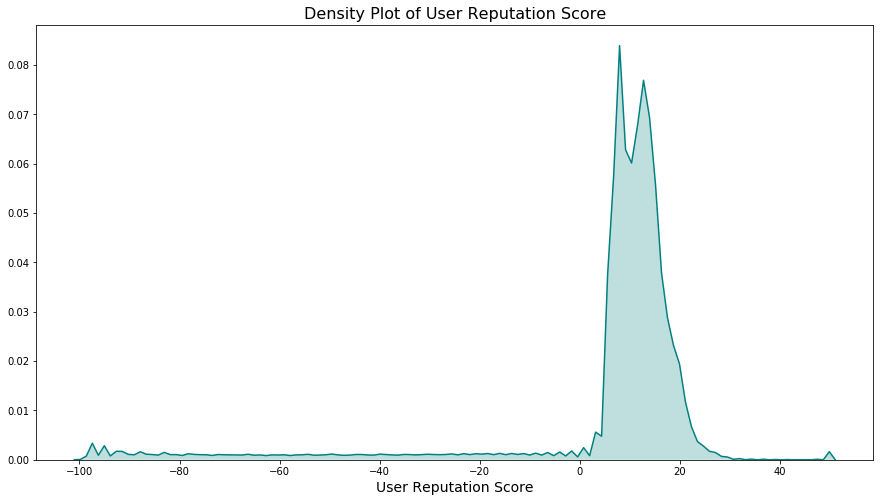

In [74]:
plt.figure(figsize=(15, 8))
ax = sns.kdeplot(df_train['roi'], shade=True, color='teal', legend=False)
ax.set_xlabel('User Reputation Score', fontsize=14)
ax.set_title('Density Plot of User Reputation Score', fontsize=16);

In [8]:
# Is this done somewhere else?
#df_train.drop(columns='issue_d', inplace=True)

In [75]:
df_train.to_pickle('data/df_training_loans_with_roi.pkl.bz2', compression='bz2')

In [51]:
training_loan_ids = tuple(df_train.index)

In [52]:
def clean_and_prepare_raw_data_for_EDA(df, training_loan_ids):
    df = drop_joint_applicant_loans(df)
    df = fix_rate_cols(df)
    df.dropna(subset=['issue_d'], inplace=True)
    df = fix_date_cols(df)
    df.sort_values(by='issue_d', inplace=True)
    df = exclude_loans_before_2010(df)
    df = clean_loan_term_col(df)
    df = only_include_36_month_loans(df)
    df = clean_employment_length(df)
    # I doubt we need missing data boolean columns for tree models.
    df = add_supplemental_rate_data(df)
    df = create_rate_difference_cols(df)
    df = create_months_since_earliest_cl_col(df)
    df = change_data_types(df)
    df['id'] = df['id'].astype(int)
    df.set_index('id', inplace=True)
    
    return df.loc[training_loan_ids, :]

In [53]:
df_cleaned_for_EDA = clean_and_prepare_raw_data_for_EDA(raw_loans, training_loan_ids)

/home/ubuntu/consumer-loan-survival-analysis/src/data-cleaning.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].str.rstrip('%').astype('float32')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/ubuntu/consumer-loan-survival-analysis/src/data-cleaning.py:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

In [54]:
df_cleaned_for_EDA.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,...,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,expected_inflation,us_mortgage_rate,prime_rate,int_minus_inflation,int_minus_mortgage,int_minus_prime,mths_since_earliest_cr
id,,,,,,,,,,,,,,,,,,,,,
478462,10000.0,36,11.83,331.339996,B,2.0,MORTGAGE,40000.0,Not Verified,2010-01-01,...,NaN,NaN,NaN,2.8,5.03,3.25,9.030000,6.800000,8.58,124
477567,10000.0,36,14.61,344.760010,D,5.0,MORTGAGE,62400.0,Not Verified,2010-01-01,...,NaN,NaN,NaN,2.8,5.03,3.25,11.809999,9.580000,11.36,162
477585,15000.0,36,16.00,527.359985,D,7.0,RENT,96000.0,Not Verified,2010-01-01,...,NaN,NaN,NaN,2.8,5.03,3.25,13.200000,10.970000,12.75,134
474990,20000.0,36,11.83,662.679993,B,5.0,MORTGAGE,105000.0,Not Verified,2010-01-01,...,NaN,NaN,NaN,2.8,5.03,3.25,9.030000,6.800000,8.58,180
477531,15000.0,36,15.31,522.229980,D,10.0,MORTGAGE,90000.0,Not Verified,2010-01-01,...,NaN,NaN,NaN,2.8,5.03,3.25,12.510000,10.280001,12.06,183


In [55]:
len(df_cleaned_for_EDA)

732069

In [65]:
with open('data/updated_rois.pickle', 'rb') as handle:
    loan_rois = pickle.load(handle)
    
df_cleaned_for_EDA['roi'] = pd.Series(loan_rois)

In [61]:
df_cleaned_for_EDA['loan_amnt'] = df_cleaned_for_EDA['loan_amnt'].astype(int)

In [68]:
df_cleaned_for_EDA.to_pickle('data/df_training_loans_for_EDA.pkl.bz2', compression='bz2')